<a href="https://colab.research.google.com/github/priyanka011011/Computer-Vision/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Nervousness_Detection**

**Overview**

The objective of nervousness detection using FEAR and NEUTRAL emotions is to develop an automated system that can accurately detect nervousness in facial expressions from images. 

**Applications**

This system can be used for various applications, such as detecting nervousness in public speaking or job interviews, which can help individuals improve their communication skills and boost their confidence.

**Methodology**

Step1. **Dataset Collection**
The first step in this project is to collect the dataset having fear and neutral emotions, which is a publicly available on websites of facial expressions. This dataset contains 9072 grayscale images of faces that are used for model training labeled with two emotions, including fear and neutral. And 2257 grayscale images of faces that are used for model validation.

Step2. **Data Preprocessing**

The collected dataset needs to be preprocessed to make it suitable for training the nervousness detection model. The preprocessing steps include resizing the images to a standard size, converting the images to grayscale, and normalizing the pixel values.

Step3.**Model Selection**

MobileNet is a computer vision model open-sourced by Google and designed for training classifiers. It uses depthwise convolutions to significantly reduce the number of parameters compared to other networks, resulting in a lightweight deep neural network. MobileNet is Tensorflow’s first mobile computer vision model.
   
    **Advantages of MobileNet**

    MobileNets are small, low-latency, low-power models parameterized  
    to meet the resource constraints of a variety of use-cases. They can be 
    built upon for classification, detection, embeddings and segmentation.


**DataSet Link**

https://drive.google.com/drive/folders/10_LYxbElgvZTtZCGf_aprqntUPB-lcGZ?usp=share_link

https://drive.google.com/drive/folders/10_LYxbElgvZTtZCGf_aprqntUPB-lcGZ?usp=share_link


## **Import Libraries**

In [21]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout, DepthwiseConv2D, BatchNormalization, GlobalAveragePooling2D
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import MobileNet
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from IPython.display import Image
from keras.preprocessing import image
import os
sns.set()

# **Load Train Data**

In [2]:

train_datagen = ImageDataGenerator(
     zoom_range = 0.2, 
     shear_range = 0.2, 
     rotation_range=30,
     width_shift_range = 0.1,
     height_shift_range = 0.1,
     horizontal_flip=True,
     rescale = 1./255
)

train_data = train_datagen.flow_from_directory(directory= "/content/drive/MyDrive/train", 
                                               target_size=(48,48), 
                                               batch_size=64,
                                               class_mode='categorical',
                                  )


train_data.class_indices

Found 9072 images belonging to 2 classes.


{'fear': 0, 'neutral': 1}

# **Load Test Data**

In [4]:
val_datagen = ImageDataGenerator(rescale = 1./255 )

val_data = val_datagen.flow_from_directory(directory= "/content/drive/MyDrive/test", 
                                           target_size=(48,48), 
                                           batch_size=64,
                                           class_mode='categorical',
                                  )

Found 2257 images belonging to 2 classes.


# **Visualize Images**

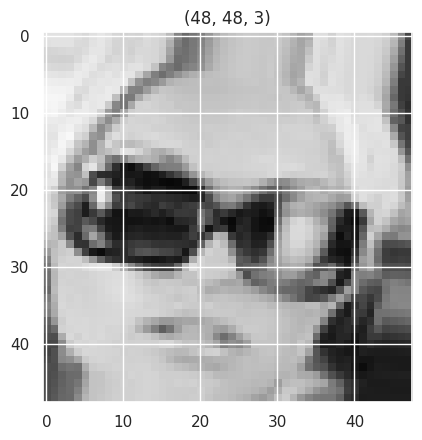

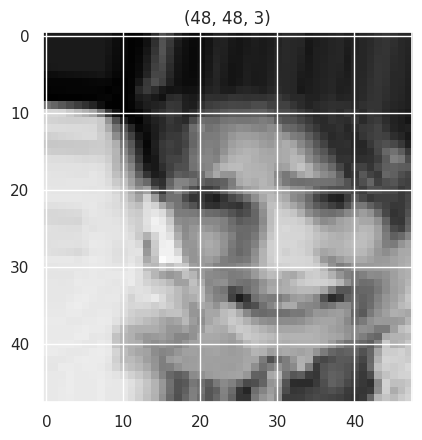

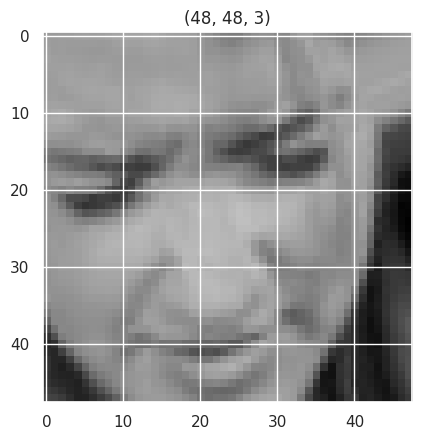

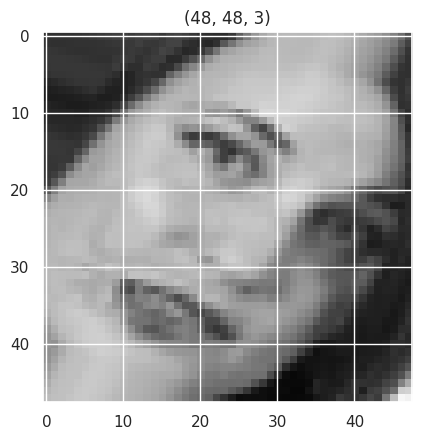

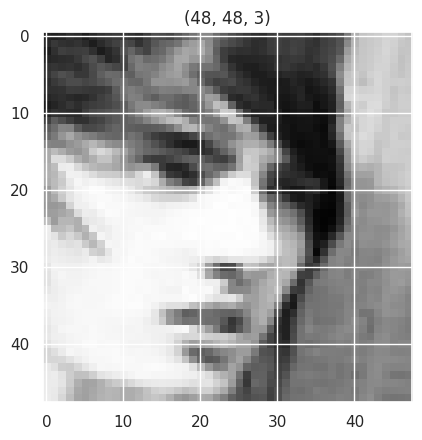

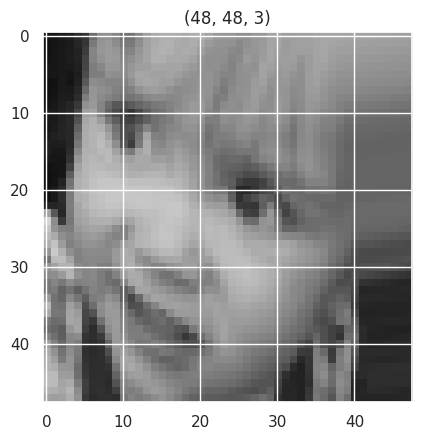

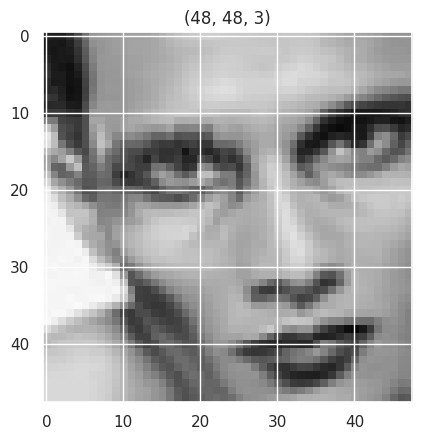

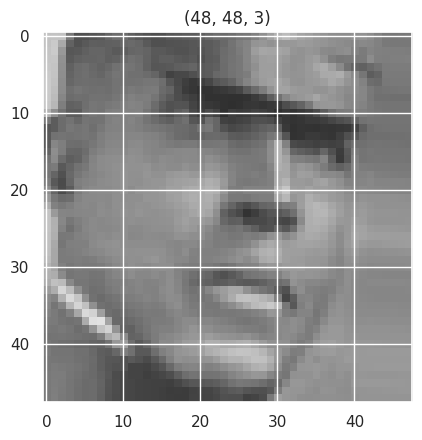

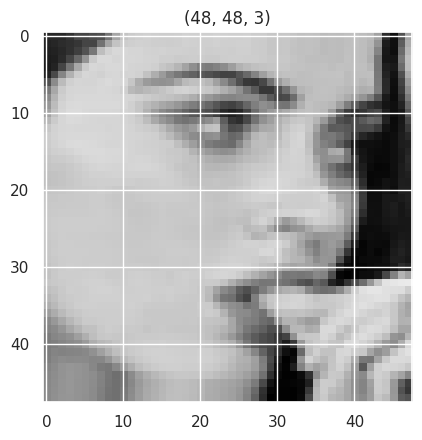

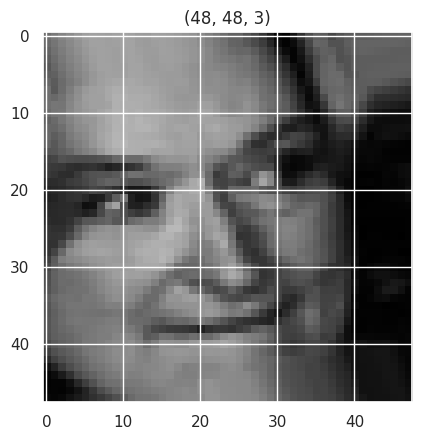

In [5]:

t_img , label = train_data.next()

def plotImages(img_arr, label):

  count = 0
  for im, l in zip(img_arr,label) :
    plt.imshow(im)
    plt.title(im.shape)
    plt.axis = False
    plt.show()
    
    count += 1
    if count == 10:
      break

plotImages(t_img, label)

# **Model Building**

In [6]:
base_model = MobileNet( weights = 'imagenet', input_shape = (48,48,3), include_top = False )

for layer in base_model.layers[:-10]:
    layer.trainable = False

for layer in base_model.layers[-10:]:
    layer.trainable = True

x = base_model.output
x= Conv2D(filters = 32, kernel_size = (1,1), strides = (1,1), activation = 'relu', padding = 'same')(x)

x= Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)

x= Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)

x= Conv2D(filters = 256, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)

x= Conv2D(filters = 512, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)

x= GlobalAveragePooling2D()(x)

x = Flatten()(x)

x = Dense(units = 256 , activation = 'relu' )(x)
x= Dropout(0.3)(x)

x = Dense(units = 512 , activation = 'relu' )(x)
x= Dropout(0.3)(x)

x = Dense(units=2 , activation = 'softmax' )(x)

model = Model(base_model.input, outputs = x)
     

17225924/17225924 [==============================] - 0s 0us/step


In [7]:
model.compile(optimizer='adam', loss='categorical_crossentropy' , metrics=['accuracy']  )
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 24, 24, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 24, 24, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 24, 24, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 24, 24, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 24, 24, 32)       128       
 ation)                                                      

# **Model Training**

In [8]:

checkpoint = ModelCheckpoint(filepath="best_model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_accuracy',
                          min_delta=0.01,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

In [10]:
hist = model.fit(train_data, epochs = 25, validation_data = val_data, callbacks = callbacks_list)

Epoch 1/25
142/142 [==============================] - ETA: 0s - loss: 0.5152 - accuracy: 0.7445
Epoch 1: val_accuracy did not improve from 0.74169
142/142 [==============================] - 124s 874ms/step - loss: 0.5152 - accuracy: 0.7445 - val_loss: 0.5201 - val_accuracy: 0.7377 - lr: 1.6000e-06
Epoch 2/25
142/142 [==============================] - ETA: 0s - loss: 0.5199 - accuracy: 0.7401
Epoch 2: val_accuracy did not improve from 0.74169
142/142 [==============================] - 108s 758ms/step - loss: 0.5199 - accuracy: 0.7401 - val_loss: 0.5189 - val_accuracy: 0.7364 - lr: 1.6000e-06
Epoch 3/25
142/142 [==============================] - ETA: 0s - loss: 0.5194 - accuracy: 0.7391
Epoch 3: val_accuracy did not improve from 0.74169
142/142 [==============================] - 102s 715ms/step - loss: 0.5194 - accuracy: 0.7391 - val_loss: 0.5183 - val_accuracy: 0.7350 - lr: 1.6000e-06
Epoch 4/25
142/142 [==============================] - ETA: 0s - loss: 0.5170 - accuracy: 0.7423
Epoch 4

# **Saving The Model**

In [30]:
model = load_model('best_model.h5')

# **Plotting the Accuracy and Loss**

In [25]:
h =  hist.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

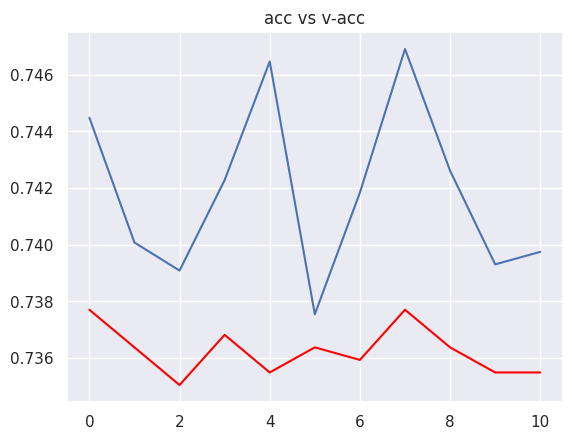

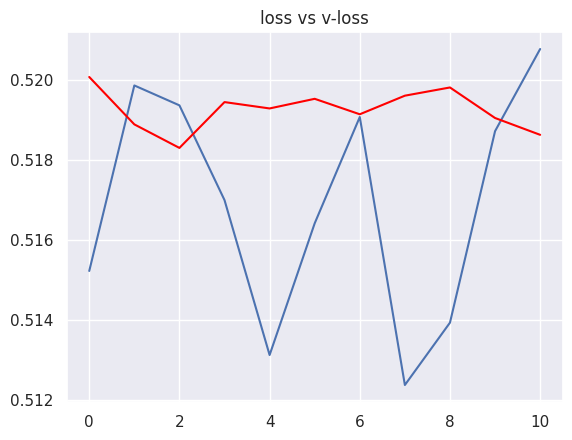

In [26]:
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'] , c = "red")
plt.title("acc vs v-acc")
plt.show()
plt.plot(h['loss'])
plt.plot(h['val_loss'] , c = "red")
plt.title("loss vs v-loss")
plt.show()

# **Prediction**

In [27]:
op = dict(zip( train_data.class_indices.values(), train_data.class_indices.keys()))
print(op)

{0: 'fear', 1: 'neutral'}


1/1 [==============================] - 0s 39ms/step
 The image is of fear


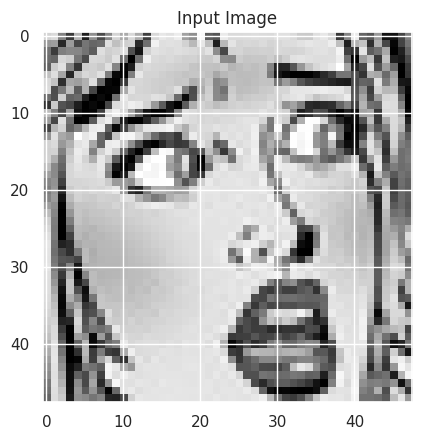

In [34]:
# path for the image to see if it predics correct class

path = "/content/PrivateTest_166793.jpg"
img = load_img(path, target_size=(48,48) )

i = img_to_array(img)/255
input_arr = np.array([i])
input_arr.shape

pred = np.argmax(model.predict(input_arr))

print(f" The image is of {op[pred]}")
  
plt.imshow(input_arr[0])
plt.title("Input Image")
plt.show()

1/1 [==============================] - 0s 46ms/step
 The image is of neutral


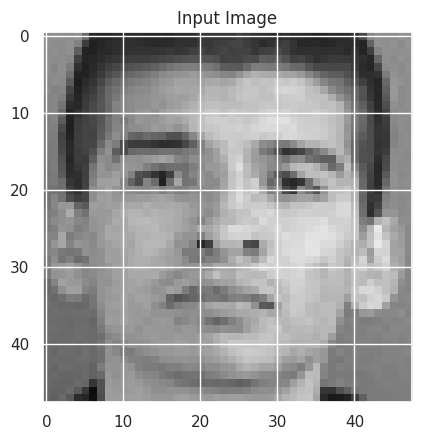

In [33]:
# path for the image to see if it predics correct class

path = "/content/PrivateTest_1129340.jpg"
img = load_img(path, target_size=(48,48) )

i = img_to_array(img)/255
input_arr = np.array([i])
input_arr.shape

pred = np.argmax(model.predict(input_arr))

print(f" The image is of {op[pred]}")
  
plt.imshow(input_arr[0])
plt.title("Input Image")
plt.show()